In [105]:
import cv2 as cv

In [106]:
cap = cv.VideoCapture('https://raw.githubusercontent.com/sseshadr/auvsi-cv-all/master/objectTracking/examples/ball.mp4')

In [107]:
success,image = cap.read()
count = 0
while success:
  cv.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = cap.read()
  print('Read a new frame: ', count)
  count += 1

Read a new frame:  0
Read a new frame:  1
Read a new frame:  2
Read a new frame:  3
Read a new frame:  4
Read a new frame:  5
Read a new frame:  6
Read a new frame:  7
Read a new frame:  8
Read a new frame:  9
Read a new frame:  10
Read a new frame:  11
Read a new frame:  12
Read a new frame:  13
Read a new frame:  14
Read a new frame:  15
Read a new frame:  16
Read a new frame:  17
Read a new frame:  18
Read a new frame:  19
Read a new frame:  20
Read a new frame:  21
Read a new frame:  22
Read a new frame:  23
Read a new frame:  24
Read a new frame:  25
Read a new frame:  26
Read a new frame:  27
Read a new frame:  28
Read a new frame:  29
Read a new frame:  30
Read a new frame:  31
Read a new frame:  32
Read a new frame:  33
Read a new frame:  34
Read a new frame:  35
Read a new frame:  36
Read a new frame:  37
Read a new frame:  38
Read a new frame:  39
Read a new frame:  40
Read a new frame:  41
Read a new frame:  42
Read a new frame:  43
Read a new frame:  44
Read a new frame:  4

In [108]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.0
The following GPU devices are available: /device:GPU:0


In [109]:
#write function for drawing the center of the ball on a frame
def draw_center(im, ymin, xmin, ymax, xmax, frame_num, center_points):
  w, h = im.size
  #we can use this to not have the circle be so massive
  circle_constraint = 40
  shape = [((xmin * w) + circle_constraint, (ymin * h) + circle_constraint), ((xmax * w) - circle_constraint,(ymax * h) - circle_constraint)]
  draw = ImageDraw.Draw(im)
  draw.ellipse(shape, fill=(0,255,0), outline=(0,0,0))

  center = ((xmin * w) + (xmax * h)) / 2
  #key on frame
  center_points[frame_num] = center


In [110]:
def display_image(image, frame_num):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

# Save Image to file.
# print("Writing to filesystem: ", f"./frame{frame_num}_detector.jpg")
  from google.colab import files
  plt.savefig(f"frame{frame_num}_detector.jpg")



def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, frame_num, center_points, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
     if class_names[i].decode("ascii") == "Ball": 
      if scores[i] >= min_score:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        #print(boxes[i])
        display_str = "{}: {}%".format(class_names[i].decode("ascii"),
        int(100 * scores[i]))
        color = colors[hash(class_names[i]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

        
        #ADD CODE FOR DRAWING CENTER ON BALL
        draw_center(image_pil, ymin, xmin, ymax, xmax, frame_num, center_points);        

        np.copyto(image, np.array(image_pil))
  return image

In [111]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [112]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [113]:
def run_detector(detector, path, frame_num, center_points):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], frame_num, center_points)

  display_image(image_with_boxes, frame_num)

<h1>Driver Code for detector:</h1>

In [114]:
#run_detector(detector, downloaded_image_path)
#we are going to use a dictionary keyed on the frames to hold the centers of the circles
center_points = {}

for i in range(51):
  run_detector(detector, f"frame{i}.jpg", i, center_points)

frame_size = (1440, 1080)
out = cv.VideoWriter('ball_detector.avi',cv.VideoWriter_fourcc(*'DIVX'), 30, frame_size)

for i in range(51):
    img = cv.imread(f"frame{i}_detector.jpg")
    out.write(img)

# print(out)
out.release()
 

print(center_points)

Output hidden; open in https://colab.research.google.com to view.

![link text](https://user-images.githubusercontent.com/77761374/163751836-c3a74ebd-57b6-40a3-a419-f3e2d401f8e4.gif)

In [115]:
center_points = list(center_points.values())

<h1>Kalman Filter for making predicitons for velocity of ball in single object detection:</h1>
https://github.com/zziz/kalman-filter/blob/master/kalman-filter.py

In [116]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)



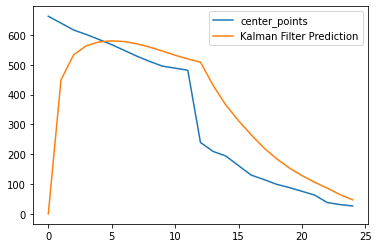

[662.8641611337662, 639.8117977380753, 616.6396933794022, 601.6220730543137, 584.9096059799194, 567.5641876459122, 548.244736790657, 528.6744296550751, 511.28815948963165, 495.54626762866974, 488.74694287776947, 481.76952481269836, 239.46467757225037, 209.42235857248306, 194.21193569898605, 161.94499254226685, 130.09809717535973, 115.33156469464302, 99.41050127148628, 88.36011081933975, 75.87828665971756, 63.17960053682327, 38.11748206615448, 31.340295374393463, 26.69766202569008]
[array([0.]), array([449.55041209]), array([533.68504119]), array([563.84626434]), array([576.82849323]), array([580.38464254]), array([577.79456954]), array([570.34692046]), array([559.29653028]), array([546.21842848]), array([532.11161732]), array([519.82314598]), array([508.81626381]), array([430.82330067]), array([365.1254659]), array([312.74148017]), array([265.19530755]), array([221.33027007]), array([185.10755523]), array([154.15168411]), array([128.46192005]), array([106.21569557]), array([86.429714])

In [117]:
def ball_tracker():
  dt = 1.0/60 
  F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
  H = np.array([1, 0, 0]).reshape(1, 3)
  Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
  R = np.array([0.5]).reshape(1, 1)

  kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
  predictions = []

  for z in center_points:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)
  import matplotlib.pyplot as plt
  plt.plot(range(len(center_points)), center_points, label = 'center_points')
  plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
  plt.legend()
  plt.show()

  print(center_points)
  print(predictions)



ball_tracker()